# ELG redshift fitting analysis

In [1]:
import numpy as np
import healpy as hp
import fitsio
import astropy.table
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib import rcParams
import h5py
%pylab inline
from scipy.signal import medfilt
import collections

# DESI modules
import desispec.io
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution
from desisim.spec_qa import redshifts as dsq_z
from desisim.spec_qa import utils as dsq_u
from desitarget.targetmask import desi_mask
import redrock.templates

Populating the interactive namespace from numpy and matplotlib


In [2]:
rcParams['font.size'] = 20

In [3]:
froot = '/project/projectdirs/desi/datachallenge/reference_runs/19.2/'
f_truth = froot + 'targets/truth.fits'
f_zcata = froot + 'spectro/redux/mini/zcatalog-mini.fits'

---

### Load data

In [4]:
# truth
truth = Table.read(f_truth, 'TRUTH')
truth_elg = Table.read(f_truth, 'TRUTH_ELG')
truth_bgs = Table.read(f_truth, 'TRUTH_BGS')
truth_lrg = Table.read(f_truth, 'TRUTH_LRG')
truth_qso = Table.read(f_truth, 'TRUTH_QSO')
truth_star = Table.read(f_truth, 'TRUTH_STAR')
truth_wd = Table.read(f_truth, 'TRUTH_WD')

# zcatalog
zcat = Table.read(f_zcata, 'ZCATALOG')

# string wsp strip
truth['TRUESPECTYPE'] = np.char.strip(truth['TRUESPECTYPE'])
truth['TEMPLATETYPE'] = np.char.strip(truth['TEMPLATETYPE'])
zcat['SPECTYPE'] = np.char.strip(zcat['SPECTYPE'])
zcat['SUBTYPE'] = np.char.strip(zcat['SUBTYPE'])

# del EXTNAME for join
del truth.meta['EXTNAME']
del truth_elg.meta['EXTNAME']
del truth_bgs.meta['EXTNAME']
del truth_lrg.meta['EXTNAME']
del truth_qso.meta['EXTNAME']
del truth_star.meta['EXTNAME']
del truth_wd.meta['EXTNAME']
del zcat.meta['EXTNAME']

### Make one table `ztruth`, including both true and fitted data
- Targets:
  1. With TARGETID in both TRUTH and ZCATALOG
  2. DESI_TARGET == ELG
  3. TARGETID >= 0

In [5]:
# select columns
truth_s = truth['TARGETID', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE', 'MAG', 'FLUX_G', 'FLUX_R', 'FLUX_Z']
zcat_s = zcat['TARGETID', 'Z', 'ZERR', 'ZWARN', 'SPECTYPE', 'SUBTYPE',
              'COEFF', 'NCOEFF', 'DELTACHI2', 'DESI_TARGET', 'HPXPIXEL',
              'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 
              'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z']
# DESI_TARGET == ELG
idx = (zcat['DESI_TARGET'] & desi_mask.mask('ELG')) != 0
zcat_s = zcat_s[idx]

# join table
ztruth = astropy.table.join(truth_s, zcat_s, keys='TARGETID', join_type='inner')

# append info for TRUTH ELGs
truth_elg_s = truth_elg['TARGETID', 'OIIFLUX', 'OIIDOUBLET']
ztruth = astropy.table.join(ztruth, truth_elg_s, keys='TARGETID', join_type='left')

# check if TARGETID >= 0
assert np.all(ztruth['TARGETID'] >= 0)

print(ztruth.colnames)

['TARGETID', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE', 'MAG', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'Z', 'ZERR', 'ZWARN', 'SPECTYPE', 'SUBTYPE', 'COEFF', 'NCOEFF', 'DELTACHI2', 'DESI_TARGET', 'HPXPIXEL', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z', 'OIIFLUX', 'OIIDOUBLET']


---

### True types check

In [6]:
print('Total number of targets selected w/ DESI_TARGET==ELG: ', len(ztruth), '\n')

print('True Spec Type:')
for st in set(ztruth['TRUESPECTYPE']):
    print('  {:>8s} : {:>6d}'.format(st, np.count_nonzero(ztruth['TRUESPECTYPE']==st)))

print('Template Type:')
for tt in set(ztruth['TEMPLATETYPE']):
    print('  {:>8s} : {:>6d}'.format(tt, np.count_nonzero(ztruth['TEMPLATETYPE']==tt)))

print('Redrock Spec Type:')
for st in set(ztruth['SPECTYPE']):
    print('  {:>8s} : {:>6d}'.format(st, np.count_nonzero(ztruth['SPECTYPE']==st)))

print('Redrock Sub Type:')
for st in set(ztruth['SUBTYPE']):
    print('  {:>8s} : {:>6d}'.format(st, np.count_nonzero(ztruth['SUBTYPE']==st)))

Total number of targets selected w/ DESI_TARGET==ELG:  17204 

True Spec Type:
    GALAXY :  17161
      STAR :     43
Template Type:
       BGS :   1576
      STAR :     43
       ELG :  15585
Redrock Spec Type:
    GALAXY :  17202
       QSO :      2
Redrock Sub Type:
           :  17204


- Some simulated BGS's and STARs are identified as ELGs.
- All simulated ELGs are still identified as ELGs (checked in another notebook).
- Q: How are `DESI_TARGET` types determined?

---

### Get Redrock templates

In [7]:
templates = dict()
for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

templates

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/redrock-templates/0.7
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


{('GALAXY', ''): <redrock.templates.Template at 0x2aaaf25cdc50>,
 ('QSO', ''): <redrock.templates.Template at 0x2aaaf25f7a90>,
 ('STAR', 'A'): <redrock.templates.Template at 0x2aaab5827c88>,
 ('STAR', 'B'): <redrock.templates.Template at 0x2aaab5827940>,
 ('STAR', 'CV'): <redrock.templates.Template at 0x2aaab5827cf8>,
 ('STAR', 'F'): <redrock.templates.Template at 0x2aaab5827a20>,
 ('STAR', 'G'): <redrock.templates.Template at 0x2aaaf25f7d68>,
 ('STAR', 'K'): <redrock.templates.Template at 0x2aaaf25f7f28>,
 ('STAR', 'M'): <redrock.templates.Template at 0x2aaaf25fc668>,
 ('STAR', 'WD'): <redrock.templates.Template at 0x2aaaf2573080>}

---

### Masks

In [8]:
# good, fail, miss and lost
objtype_mask, z_mask, survey_mask, dv_mask, zwarn_mask = dsq_z.criteria(ztruth, objtype='ELG')
good_mask = zwarn_mask & dv_mask & objtype_mask & z_mask
fail_mask = zwarn_mask & (~dv_mask) & objtype_mask & z_mask
miss_mask = (~zwarn_mask) & dv_mask & objtype_mask & z_mask
lost_mask = (~zwarn_mask) & (~dv_mask) & objtype_mask & z_mask
tot_mask = objtype_mask & z_mask

ntot = np.count_nonzero(tot_mask)

ngood = np.count_nonzero(good_mask)
nfail = np.count_nonzero(fail_mask)
nmiss = np.count_nonzero(miss_mask)
nlost = np.count_nonzero(lost_mask)

pgood = ngood * 100 / ntot
pfail = nfail * 100 / ntot
pmiss = nmiss * 100 / ntot
plost = nlost * 100 / ntot

print('     ELG     ntarg    good   fail   miss   lost')
print('{:>8s}  {:8d}   {:5d}  {:5d}  {:5d}  {:5d}'.format('number', ntot, ngood, nfail, nmiss, nlost))
print('{:>8s}  {:8.1f}   {:5.1f}  {:5.1f}  {:5.1f}  {:5.1f}'.format('percent', 100.0, pgood, pfail, pmiss, plost))

ztruth_good = ztruth[good_mask]
ztruth_fail = ztruth[fail_mask]
ztruth_miss = ztruth[miss_mask]
ztruth_lost = ztruth[lost_mask]

     ELG     ntarg    good   fail   miss   lost
  number     17204   13918    108   1415   1763
 percent     100.0    80.9    0.6    8.2   10.2


In [9]:
# good : correct redshift and ZWARN==0
# fail : bad redshift and ZWARN==0 (i.e. catastrophic failures)
# miss : correct redshift and ZWARN!=0 (missed opportunities)
# lost : wrong redshift and ZWARN!=0 (wrong but at least we know it)

---

## Basic Statistics

In [10]:
def one_bits(num):
    '''Return the positions of binary bits == 1.'''
    s = '{:0>64b}'.format(num)[::-1]
    pos = []
    for i, s_ in enumerate(s):
        if s_ == '1': pos.append(i)
    return pos

def basic_stat(fs, savef=False):
    '''fs = good, fail, miss or lost'''
    if fs == 'good': zz = ztruth_good
    elif fs == 'fail': zz = ztruth_fail
    elif fs == 'miss': zz = ztruth_miss
    elif fs == 'lost': zz = ztruth_lost
    elif fs == 'all': zz = ztruth
    else: assert 0

    # make masks for Template types
    zz_masks = {}
    for st in set(zz['TEMPLATETYPE']):
        zz_masks[st] = (zz['TEMPLATETYPE']==st)
    
    # Template Type
    print('Template Type:')
    zz_counts = {}
    for st in zz_masks.keys():
        zz_counts[st] = np.count_nonzero(zz_masks[st])
        print('  {:>8s} : {:>6d}'.format(st, zz_counts[st]))
    zz_counts = collections.OrderedDict(sorted(zz_counts.items(), key=lambda x: -x[1])) # keep order

    fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # plot distribution of Delta chi2
    print('Delta chi2 : min : {:.2f}, max : {:.2f}'.format(np.amin(zz['DELTACHI2']), np.amax(zz['DELTACHI2'])))
    for kk in zz_counts.keys():
        mm = zz_masks[kk]
        ax.scatter(zz[mm]['TRUEZ'], zz[mm]['DELTACHI2'], alpha=0.3, label=kk)
    ax.axhline(9, c='r', ls='--')
    ax.set_xlim(0); ax.set_ylim(0, 20)
    ax.set_xlabel('True Redshift'); ax.set_ylabel('$\Delta \chi^2$')
    ax.set_title('ELG {}'.format(fs)); ax.legend()
    
    # plot histgram of Delta chi2
    for kk in zz_counts.keys():
        mm = zz_masks[kk]
        ax2.hist(zz[mm]['DELTACHI2'], range=(0, 20), bins=40, alpha=0.5, label=kk)
    ax2.set_xlabel('$\Delta \chi^2$'); ax2.set_ylabel('counts')
    ax2.set_xlim(0, 20)
    ax2.legend()
    
    # plot redshift scatter
    for kk in zz_counts.keys():
        mm = zz_masks[kk]
        ax3.scatter(zz[mm]['TRUEZ'], zz[mm]['Z'], alpha=0.3, label=kk)
    ax3.set_xlabel('True Redshift'); ax3.set_ylabel('Redrock Redshift')
    ax3.plot([0, 1.6], [0, 1.6], 'r-')
    ax3.legend()
    
    # plot True magnitude vs Delta chi2
    for kk in zz_counts.keys():
        mm = zz_masks[kk]
        ax4.scatter(zz[mm]['MAG'], np.log10(zz[mm]['DELTACHI2']), alpha=0.3, label=kk)
    ax4.set_xlabel('MAG'); ax4.set_ylabel('$\log_{10}\Delta \chi^2$')
    ax4.set_xlim(20, 24); ax4.set_ylim(-2.5, 4.5)
    ax4.invert_xaxis()
    ax4.axhline(np.log10(9), c='r', ls='--')
    ax4.legend()
    
    if savef:
        plt.savefig('../figures/stat_{:s}.pdf'.format(fs))

    plt.show()
    
    # zwarning bits
    print('ZWARN bits:\n Number : bits')
    for zw in set(zz['ZWARN']):
        print('{:>7d} : '.format(np.count_nonzero(zz['ZWARN']==zw)), one_bits(zw))
    
    print('-'*90)

### All

Template Type:
       BGS :   1576
      STAR :     43
       ELG :  15585
Delta chi2 : min : 0.00, max : 35328.09


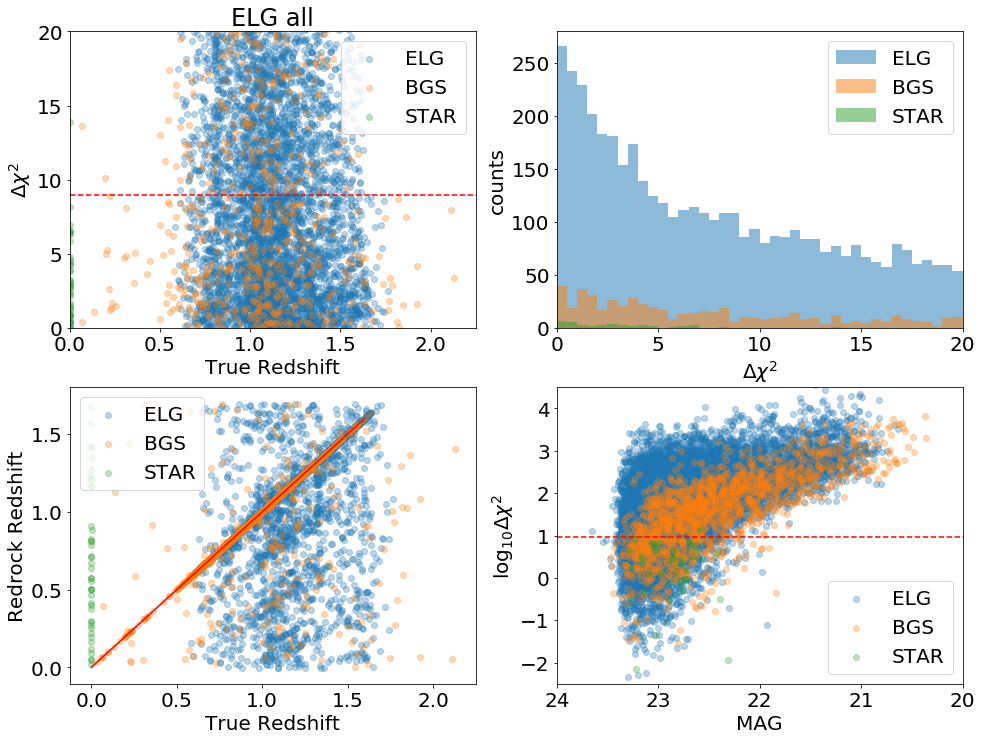

ZWARN bits:
 Number : bits
  14026 :  []
   3176 :  [2]
      1 :  [2, 10]
      1 :  [2, 5]
------------------------------------------------------------------------------------------


In [11]:
basic_stat('all')

### Good

Template Type:
       BGS :   1189
       ELG :  12729
Delta chi2 : min : 9.01, max : 35328.09


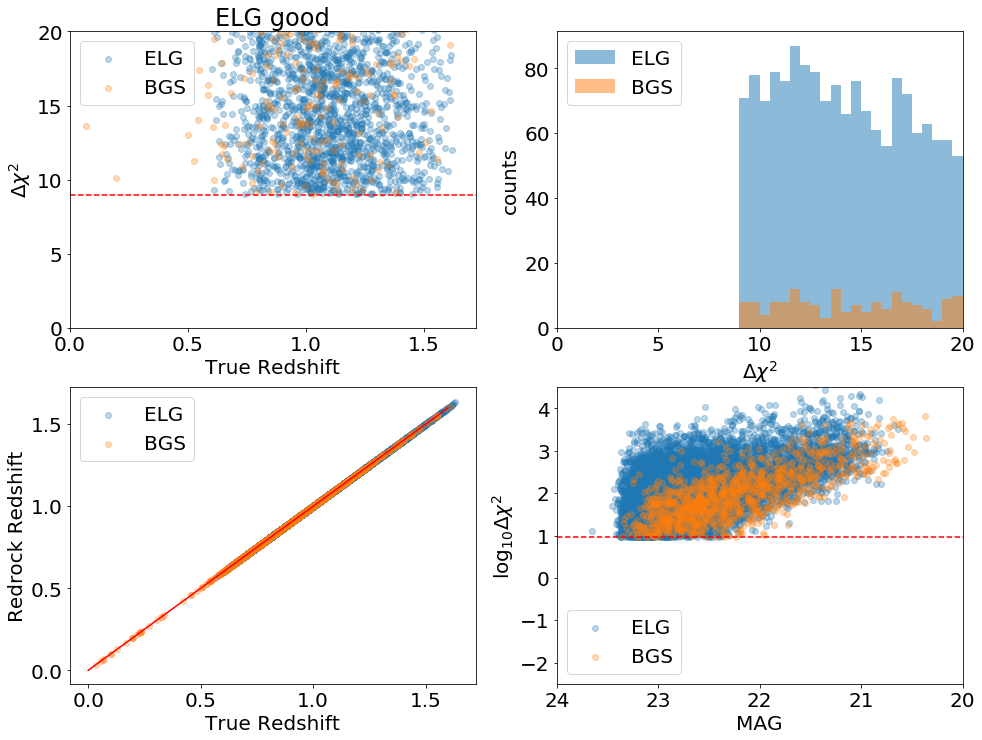

ZWARN bits:
 Number : bits
  13918 :  []
------------------------------------------------------------------------------------------


In [12]:
basic_stat('good')

### Fail

Template Type:
       BGS :     17
      STAR :      1
       ELG :     90
Delta chi2 : min : 9.00, max : 108.84


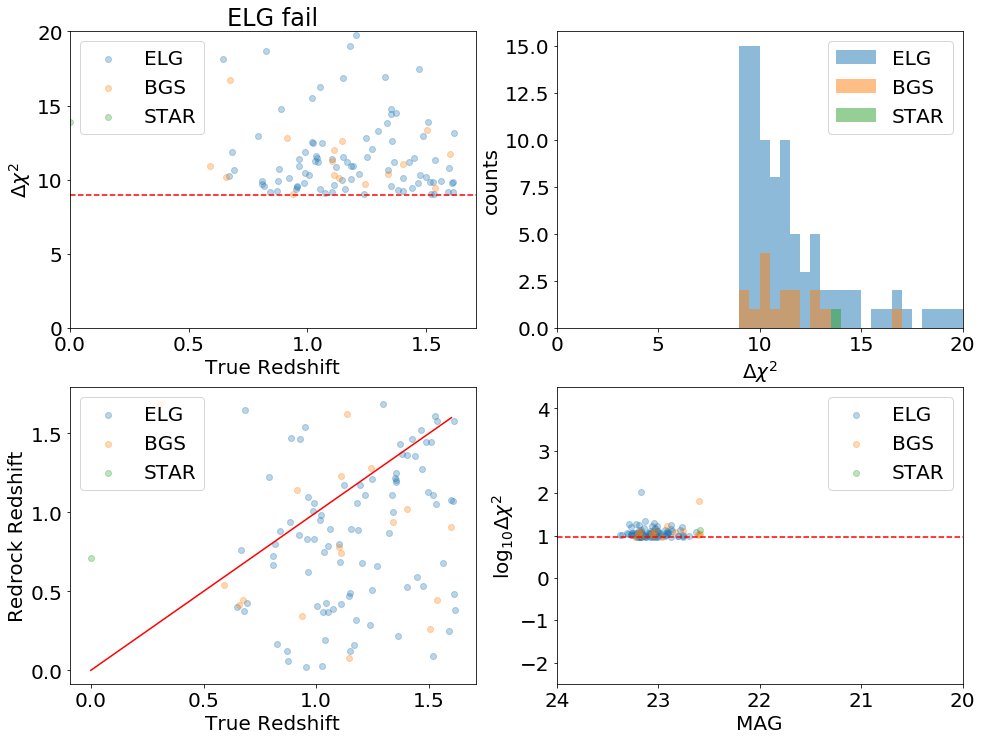

ZWARN bits:
 Number : bits
    108 :  []
------------------------------------------------------------------------------------------


In [13]:
basic_stat('fail', savef=True)

### Miss

Template Type:
       BGS :    162
       ELG :   1253
Delta chi2 : min : 0.01, max : 9.00


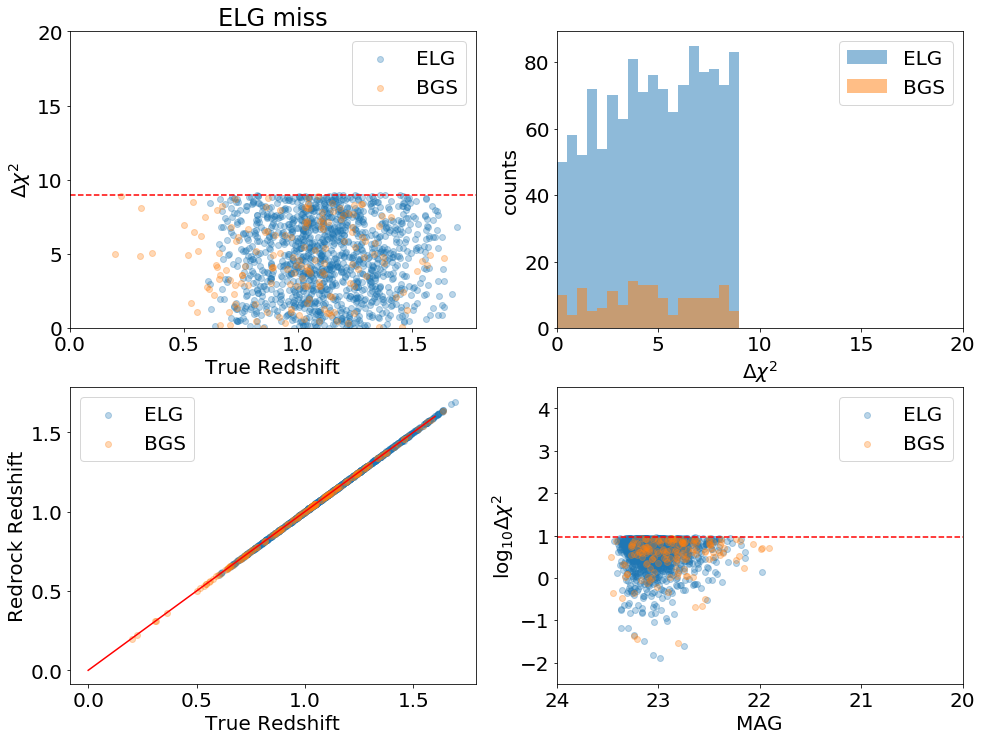

ZWARN bits:
 Number : bits
   1414 :  [2]
      1 :  [2, 10]
------------------------------------------------------------------------------------------


In [14]:
basic_stat('miss')

### Lost

Template Type:
       BGS :    208
      STAR :     42
       ELG :   1513
Delta chi2 : min : 0.00, max : 8.91


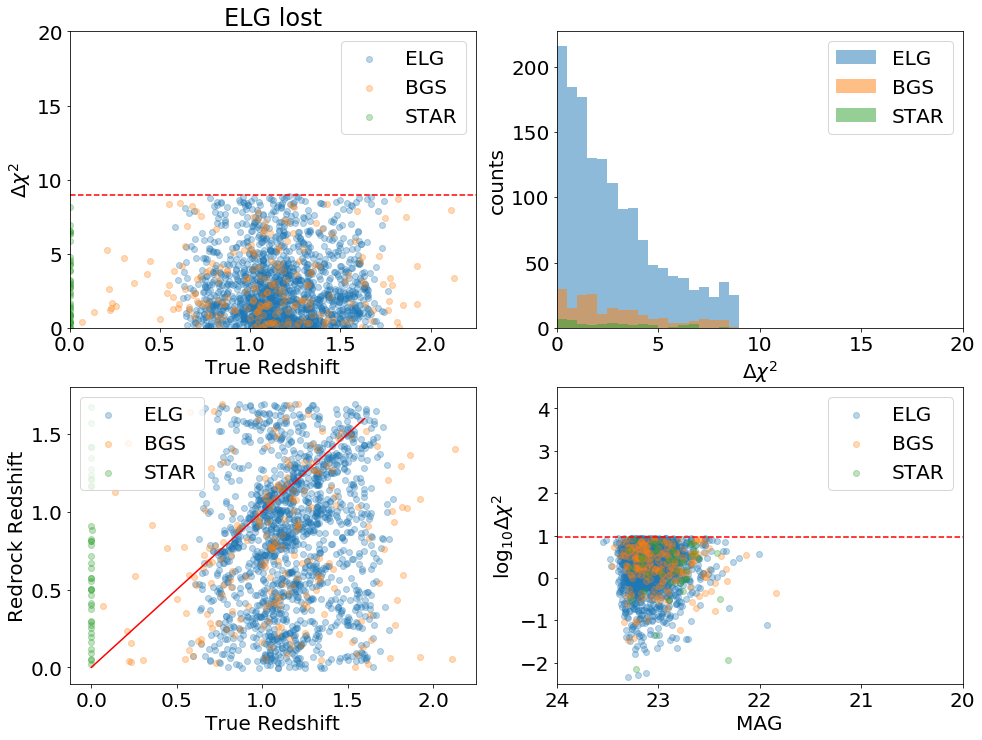

ZWARN bits:
 Number : bits
   1762 :  [2]
      1 :  [2, 5]
------------------------------------------------------------------------------------------


In [15]:
basic_stat('lost')

---

### Notes
- `ZWARN` bits definition: https://github.com/desihub/redrock/blob/master/py/redrock/zwarning.py
  -  2 : chi-squared of best fit is too close to that of second best
  -  5 : chi-squared minimum at edge of the redshift fitting range
  - 10 : Bad parabola fit to the chi2 minimum
- It seems that for this fitting, `small delta chi2` is set at `9`. And this is the dominant (and almost only) criteria that determines `ZWARN == 0` or `ZWARN != 0` for all the ELG targets.
  - set in https://github.com/desihub/redrock/blob/master/py/redrock/constants.py
- We can get rid of most fail targets by increasing `small delta chi2`, but some good targets would be sacrificed.
- fail, miss and lost are dominated by faint targets

---

## $\Delta\chi^2$

In [33]:
def plot_chi2vs(clr, ax):
    '''plot Delta chi2 vs some property'''
    ax.set_xlabel(clr)
    
    lls = ['good', 'fail', 'miss', 'lost']
    zzs = [ztruth_good, ztruth_fail, ztruth_miss, ztruth_lost]
    for ll, zz in zip(lls, zzs):
        if clr[-2] == '-':
            ax.scatter(zz[clr[:-3]+clr[-3]]-zz[clr[:-3]+clr[-1]], np.log10(zz['DELTACHI2']), alpha=0.3, label=ll)
        elif clr[-2] == '/':
            ax.scatter(-2.5*np.log10(zz[clr[:-3]+clr[-3]]/zz[clr[:-3]+clr[-1]]), np.log10(zz['DELTACHI2']), alpha=0.3, label=ll)
            ax.set_xlabel('$-2.5\log_{10}$'+'({:s})'.format(clr))
        elif clr == 'OIIFLUX':
            ax.scatter(np.log10(zz[clr]), np.log10(zz['DELTACHI2']), alpha=0.3, label=ll)
            ax.set_xlabel('$\log_{10}$OIIFLUX')
        else:
            ax.scatter(zz[clr], np.log10(zz['DELTACHI2']), alpha=0.3, label=ll)
    
    ax.axhline(np.log10(9), c='k', ls='--')
    
    if clr == 'MAG': ax.invert_xaxis()

    ax.set_ylabel('$\log_{10}\Delta\chi^2$')
    ax.legend()

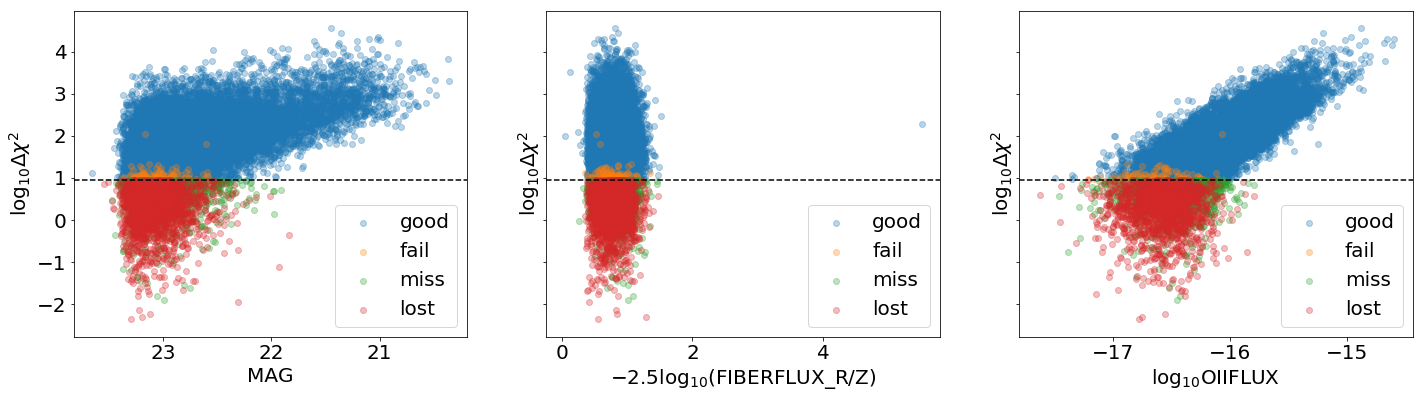

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6), sharey='row')
pps = ['MAG', 'FIBERFLUX_R/Z', 'OIIFLUX']#'OIIDOUBLET']
for pp, ax in zip(pps, axs): plot_chi2vs(pp, ax)

### Proper $\Delta \chi^2$ criteria?

In [18]:
objtype_mask, z_mask, survey_mask, dv_mask, zwarn_mask = dsq_z.criteria(ztruth, objtype='ELG')

def perc_chi2(sdchi2):
    '''return the fractions of good, fail, miss and lost given small delta chi2'''
    # new zwarn mask
    zwarn_mask = (ztruth['DELTACHI2'] >= sdchi2)
    
    good_mask = zwarn_mask & dv_mask & objtype_mask & z_mask
    fail_mask = zwarn_mask & (~dv_mask) & objtype_mask & z_mask
    miss_mask = (~zwarn_mask) & dv_mask & objtype_mask & z_mask
    lost_mask = (~zwarn_mask) & (~dv_mask) & objtype_mask & z_mask
    tot_mask = objtype_mask & z_mask # this is actually all True's
    
    ntot = np.count_nonzero(tot_mask)

    ngood = np.count_nonzero(good_mask)
    nfail = np.count_nonzero(fail_mask)
    nmiss = np.count_nonzero(miss_mask)
    nlost = np.count_nonzero(lost_mask)

    pgood = ngood * 100 / ntot
    pfail = nfail * 100 / ntot
    pmiss = nmiss * 100 / ntot
    plost = nlost * 100 / ntot
    
    return pgood, pfail, pmiss, plost

In [19]:
sdchi2s = np.linspace(1, 30, 30)

res = collections.OrderedDict({'good':[], 'fail':[], 'miss':[], 'lost':[]})

for sdchi2 in sdchi2s:
    pgood, pfail, pmiss, plost = perc_chi2(sdchi2)
    res['good'].append(pgood); res['fail'].append(pfail)
    res['miss'].append(pmiss); res['lost'].append(plost)

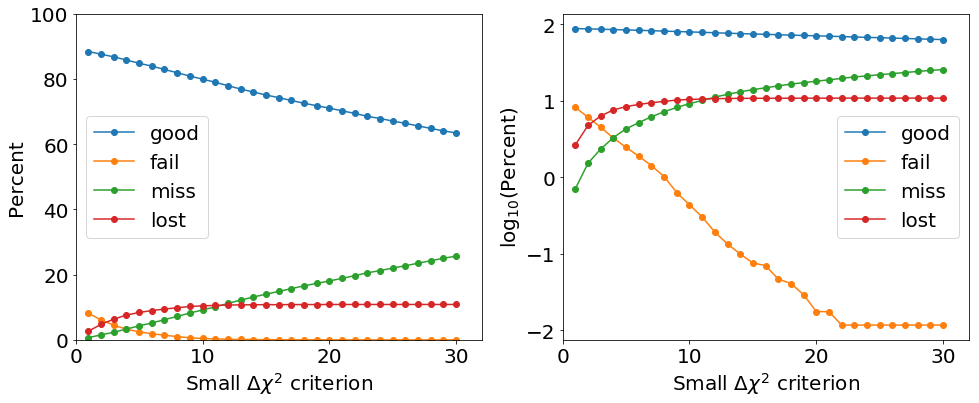

In [20]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(16, 6))

for kk in res.keys():
#     if kk != 'fail': continue
    ax.plot(sdchi2s, res[kk], 'o-', label=kk)
    ax1.plot(sdchi2s, np.log10(res[kk]), 'o-', label=kk)

ax.set_xlim(0, 32); ax1.set_xlim(0, 32)
ax.set_ylim(0, 100)
ax.set_xlabel('Small $\Delta\chi^2$ criterion'); ax.set_ylabel('Percent')
ax1.set_xlabel('Small $\Delta\chi^2$ criterion'); ax1.set_ylabel('$\log_{10}$(Percent)')

ax.legend(); ax1.legend()

plt.savefig('../figures/fraction.pdf')
plt.show()

---

## Color-color

In [48]:
def plot_colorsel(ff, ax, zbin=None, cc='GRRZ'):
    '''plot color-color diagram'''
#     lls = ['good', 'miss', 'lost', 'fail']
    lls = ['good', 'fail']
    if zbin == None:
        zzs = [ztruth_good, ztruth_fail]#, ztruth_miss, ztruth_lost]
    else:
        zzs = []
        for zt in [ztruth_good, ztruth_fail]:#, ztruth_miss, ztruth_lost]:
            z_mask = (zt['Z'] >= zbin[0]) & (zt['Z'] <= zbin[1])
            zzs.append(zt[z_mask])

    for ll, zz in zip(lls, zzs):
        ax.scatter(-2.5 * np.log10(zz[ff+'_'+cc[2]] / zz[ff+'_'+cc[3]]), 
                   -2.5 * np.log10(zz[ff+'_'+cc[0]] / zz[ff+'_'+cc[1]]), alpha=0.3, label=ll)

    ax.set_xlabel('$-2.5 \log_{10}$' + '({:s} / {:s})'.format(cc[2], cc[3]))
    ax.set_ylabel('$-2.5 \log_{10}$' + '({:s} / {:s})'.format(cc[0], cc[1]))
    ax.set_title(ff)
    ax.legend()

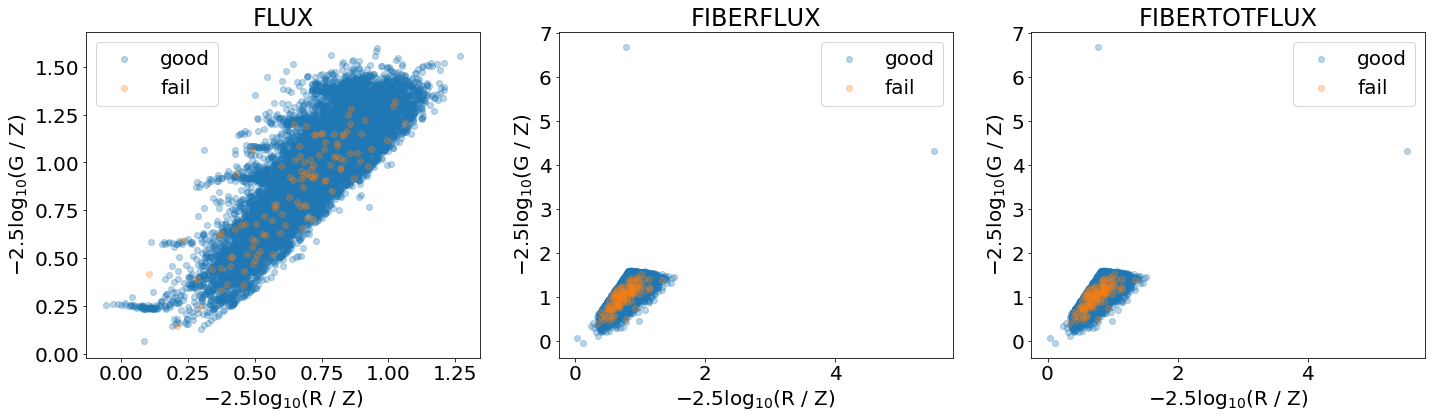

In [49]:
# g-z vs r-z
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
pps = ['FLUX', 'FIBERFLUX', 'FIBERTOTFLUX']
for pp, ax in zip(pps, axs): plot_colorsel(pp, ax, cc='GZRZ')

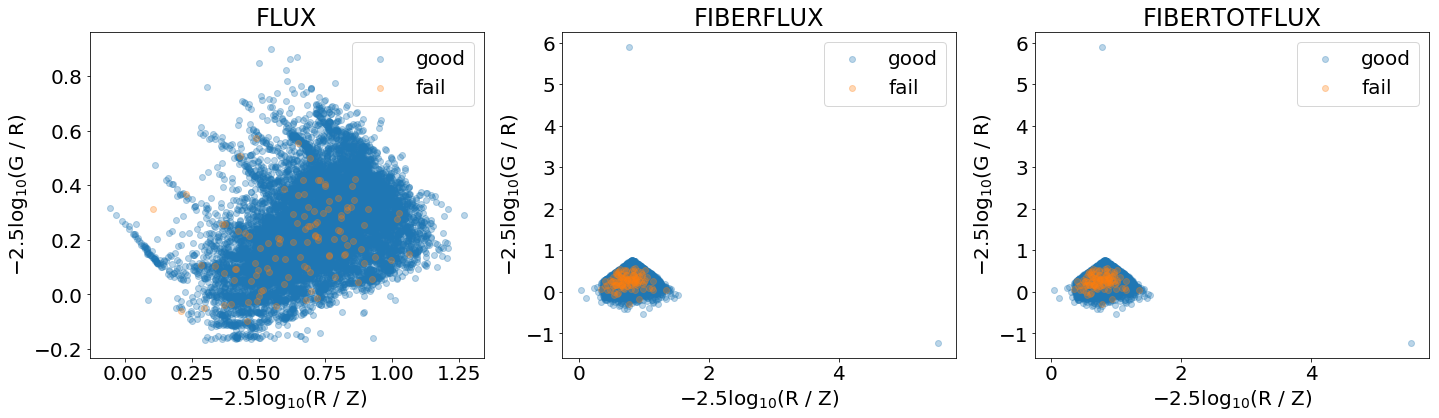

In [50]:
# g-r vs r-z
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
pps = ['FLUX', 'FIBERFLUX', 'FIBERTOTFLUX']
for pp, ax in zip(pps, axs): plot_colorsel(pp, ax)

redshift bin:  [0.9, 1.1]


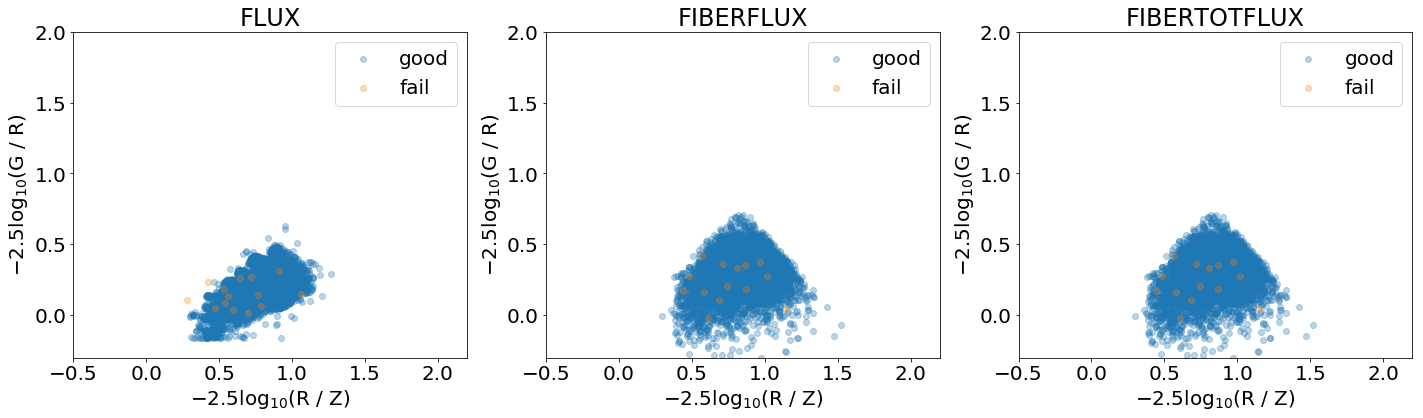

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
pps = ['FLUX', 'FIBERFLUX', 'FIBERTOTFLUX']
zbin = [0.9, 1.1]; print('redshift bin: ', zbin)
for pp, ax in zip(pps, axs):
    plot_colorsel(pp, ax, zbin)
    ax.set_xlim(-0.5, 2.2); ax.set_ylim(-0.3, 2.0)

plt.savefig('../figures/color-color.pdf')

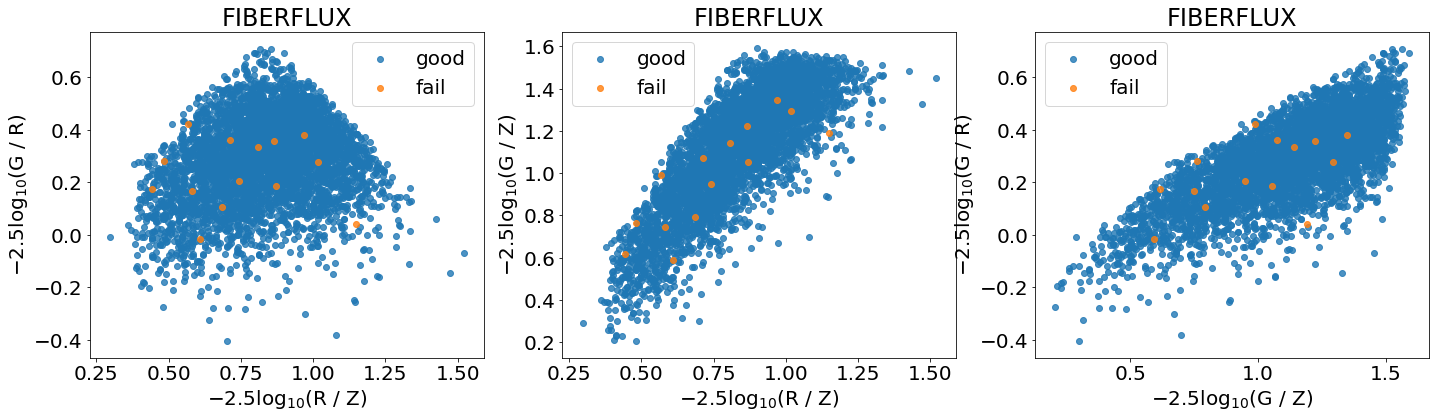

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

lls = ['good', 'fail']
zbin = [0.9, 1.1]
ccs = ['GRRZ', 'GZRZ', 'GRGZ']
ff = 'FIBERFLUX'

zzs = []
for zt in [ztruth_good, ztruth_fail]:
    z_mask = (zt['Z'] >= zbin[0]) & (zt['Z'] <= zbin[1])
    zzs.append(zt[z_mask])

for cc, ax in zip(ccs, axs):
    for ll, zz in zip(lls, zzs):
        ax.scatter(-2.5 * np.log10(zz[ff+'_'+cc[2]] / zz[ff+'_'+cc[3]]), 
                   -2.5 * np.log10(zz[ff+'_'+cc[0]] / zz[ff+'_'+cc[1]]), alpha=0.8, label=ll)
        ax.set_xlabel('$-2.5 \log_{10}$' + '({:s} / {:s})'.format(cc[2], cc[3]))
        ax.set_ylabel('$-2.5 \log_{10}$' + '({:s} / {:s})'.format(cc[0], cc[1]))
        ax.set_title(ff)
        ax.legend()

plt.savefig('../figures/color-color.pdf')

### Notes
- The shape of FIBERFLUX figure look similar to the selected polygon area in Figure 3.10 on P.54 in DESI FDR-Science paper.
- The color selection should have been applied in the simulation.

---

## OII Flux

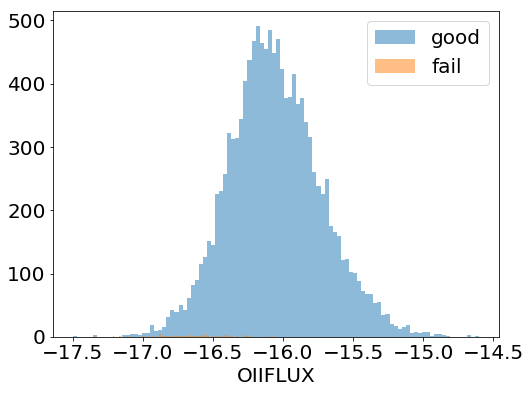

In [41]:
lls = ['good', 'fail']#, 'miss', 'lost']
zzs = [ztruth_good, ztruth_fail]#, ztruth_miss, ztruth_lost]

fig, (ax) = plt.subplots(1, 1, figsize=(8, 6))

for ll, zz in zip(lls, zzs):
    ax.hist(np.log10(zz['OIIFLUX']), bins=100, alpha=0.5, label=ll)

ax.set_xlabel('OIIFLUX')
ax.legend()

plt.show()

---

## TODO

- So the general purpose is to improve the redshift fitting efficiency, i.e. both high good percent and acceptable fail percent.
- Now all the not-good (i.e. fail, miss and lost) fittings are dominated by faint targets, where I guess the typical emission lines are not that significant compared with other confusing cosmic emissions.

---

## Looking into spectra of individual targets

In [25]:
# one target related functions

def get_specot(tid):
    '''get the spectra object for one target given the target id'''
    idx = (ztruth['TARGETID'] == tid)
    ipix = ztruth[idx]['HPXPIXEL'][0]
    spec_path = 'spectro/redux/mini/spectra-64/{:d}/{:d}/'.format(ipix//100, ipix)
    specobj = desispec.io.read_spectra(froot + spec_path + 'spectra-64-{:d}.fits'.format(ipix))
    specot = specobj.select(targets=[tid])
    return specot


def get_tempot(tid):
    '''get the best-fit template wave and flux for one target'''
    idx = (ztruth['TARGETID'] == tid)
    spectype = ztruth[idx]['SPECTYPE'][0]
    subtype = ztruth[idx]['SUBTYPE'][0]
    fulltype = (spectype, subtype)
    ncoeff = ztruth[idx]['NCOEFF'][0]
    coeff = ztruth[idx]['COEFF'][0][:ncoeff]
    str_ = 'coeff:\n'
    for i in range(ncoeff):
        str_ += '  {:>8.2f}'.format(coeff[i])
        if i == 4: str_ += '\n'
    print(str_)
    tflux = templates[fulltype].flux.T.dot(coeff)
    z = ztruth[idx]['Z'][0]
    twave = templates[fulltype].wave * (1 + z)
    return twave, tflux


def get_zchi2ot(tid, tt):
    '''get the redshift scanned chi2 for one target'''
    idx = (ztruth['TARGETID'] == tid)
    ipix = ztruth[idx]['HPXPIXEL'][0]
    spec_path = 'spectro/redux/mini/spectra-64/{:d}/{:d}/'.format(ipix//100, ipix)
    rrh5 = h5py.File(froot + spec_path + 'redrock-64-{:d}.h5'.format(ipix), 'r')

    idx = (rrh5['targetids'][:] == tid)
    redshifts = rrh5['zscan'][tt]['redshifts']
    zchi2 = rrh5['zscan'][tt]['zchi2'][idx, :][0]
    return redshifts, zchi2


eml_colors = collections.OrderedDict({'OII-d1':'tab:blue', 'OII-d2':'tab:blue',
                                      'OIII-d1':'tab:orange', 'OIII-d2':'tab:orange',
                                      'H-alpha':'tab:green', 'H-beta':'tab:brown'})
emls = collections.OrderedDict({'OII-d1':3726, 'OII-d2':3729,
                                'OIII-d1':4959, 'OIII-d2':5007,
                                'H-alpha':6563, 'H-beta':4861})


def plot_spec(ax, z, specot, twave, tflux, ss=0, ks=1):
    '''plot the observed spectrum for one target, along with the template'''
    bwave = specot.wave['b']; rwave = specot.wave['r']; zwave = specot.wave['z']
    bflux = specot.flux['b']; rflux = specot.flux['r']; zflux = specot.flux['z']
    
    # plot a few emission lines
    for e in emls.keys():
        ax.axvline((1+z)*emls[e], label=e, c=eml_colors[e], alpha=0.5, ls='--')
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

    # spectral resolution
    tbflux = Resolution(specot.resolution_data['b'][0]).dot(resample_flux(specot.wave['b'], twave, tflux))
    trflux = Resolution(specot.resolution_data['r'][0]).dot(resample_flux(specot.wave['r'], twave, tflux))
    tzflux = Resolution(specot.resolution_data['z'][0]).dot(resample_flux(specot.wave['z'], twave, tflux))

    ax.plot(bwave, medfilt(bflux[ss], ks), 'k-', alpha=0.3)
    ax.plot(rwave, medfilt(rflux[ss], ks), 'k-', alpha=0.3)
    ax.plot(zwave, medfilt(zflux[ss], ks), 'k-', alpha=0.3)

    ax.plot(bwave, tbflux, 'r-'); ax.plot(rwave, trflux, 'r-'); ax.plot(zwave, tzflux, 'r-')

    ax.text(0.8, 0.9, 'spectrum: {:d}'.format(ss), transform=ax.transAxes)

    ax.set_xlabel('wavelength')
    ax.set_ylabel('flux')


def plot_chi2(ax, redshifts, zchi2, tt, truez, z):
    '''plot chi2 vs redshift'''
    ax.axvline(truez, label='TRUEZ: {:f}'.format(truez), c='tab:red', ls='--', alpha=0.5)
    ax.axvline(z, label='        Z: {:f}'.format(z), c='tab:green', ls='--', alpha=0.5)
    ax.plot(redshifts, zchi2, label=tt)
    
    ax.set_xlabel('redshift')
    ax.set_ylabel('$\chi^2$')
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

coeff:
     79.52     -3.65   -103.90    -11.51      5.46
    160.98     19.10     68.27      3.62      5.09
idx: 34, target id: 288230398364747784
   true z: 1.297379
redrock z: 1.686315
Template type: ELG
number of spectra:  2
Emission lines are plotted at redshift: Z


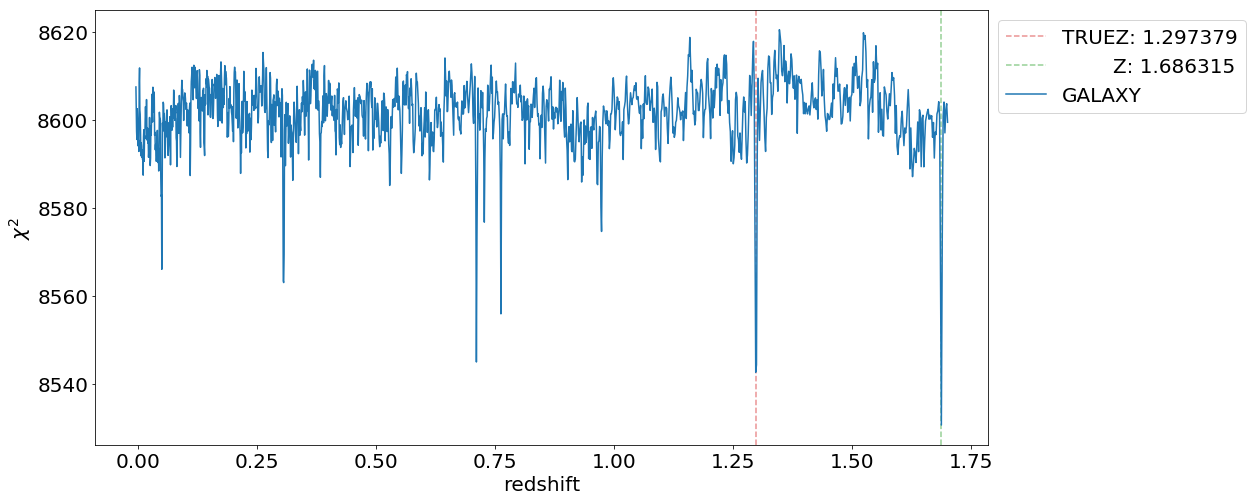

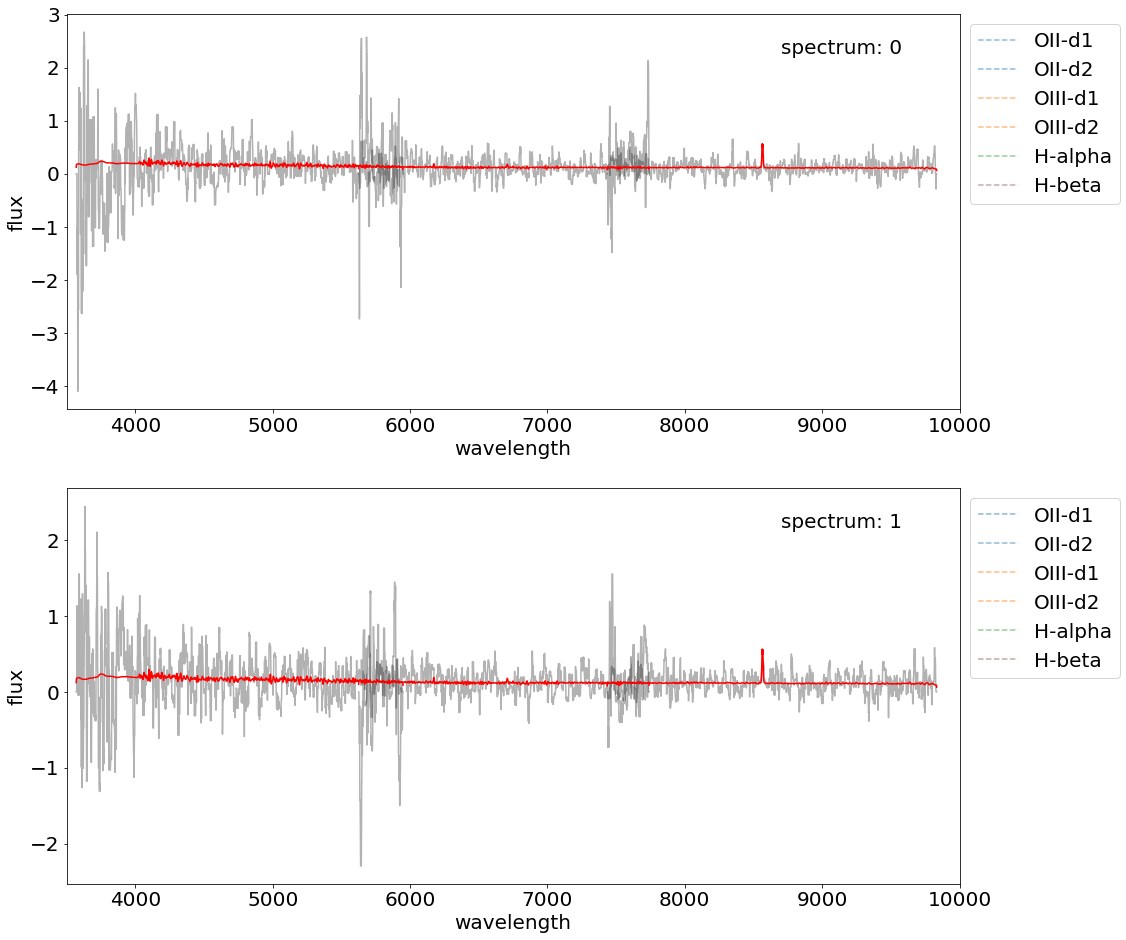

In [26]:
ztt = ztruth_fail
# ztt = ztruth_good
idxs = np.random.randint(0, len(ztt), 1)

for idx in idxs:
    zot = ztt[idx]

    tid = zot['TARGETID']
    specot = get_specot(tid)
    twave, tflux = get_tempot(tid)
    num_spec = specot.num_spectra()

    print('idx: {:d}, target id: {:d}'.format(idx, tid))
    print('   true z: {:f}'.format(zot['TRUEZ']))
    print('redrock z: {:f}'.format(zot['Z']))
    print('Template type:', zot['TEMPLATETYPE'])

    tt = 'GALAXY'
    redshifts, zchi2 = get_zchi2ot(tid, tt)
    fig, (ax) = plt.subplots(1, 1, figsize=(16, 8))
    plot_chi2(ax, redshifts, zchi2, tt, zot['TRUEZ'], zot['Z'])
    # ax.set_xlim(0.85, 0.95)

    print('number of spectra: ', num_spec)
    fig, axs = plt.subplots(num_spec, 1, figsize=(16, 8*num_spec))
    # z = zot['TRUEZ']; print('Emission lines are plotted at redshift: TRUEZ')
    z = zot['Z']; print('Emission lines are plotted at redshift: Z')
    for i, ax in enumerate(axs):
        plot_spec(ax, z, specot, twave, tflux, ss=i, ks=15)
    #     ax.set_ylim(-1, 1)
        ax.set_xlim(3500, 10000)
    
    plt.show()

---